we will perform prediction using two correlated data series,
we will first import our files into Colab.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

typ = int(input("Please enter a number for the file type you would like to upload (1).xlsx (2).csv:\n"))

if typ != 1 and typ != 2:
  print(colored('ERROR: invalid input entered. Please restart this section.', 'red'))

else:
  loc = int(input("Please enter a number for the resource location from which to import data (1)Google Drive (2)Local Drive:\n"))
  
  print('NOTE: For the following data, be sure a date column exists for each.')

  if loc != 1 and loc != 2:
    print(colored('ERROR: invalid input entered. Please restart this section.', 'red'))

  else:
    if loc == 1: # Google Drive
      
      print("Click on the link to get authentication to allow Google to access your Drive. You should see a screen with\n“Google Cloud SDK wants to access your Google Account” at the top. After you allow permission,\ncopy the given verification code and paste it in the box in Colab.")
      from google.colab import drive
      drive.mount('/content/drive')
      print()

      if typ == 1: # .xlsx
        FileName = input("Please copy the path of your .xlsx file and paste it here,\nyou can do that by going to the lefthand bar and clicking on the folder icon,\nthen go to your mounted drive and go to your file,\nthen right click there and copy the path. ")
        print("\nLoading data...\n")

        dataFrame = pd.ExcelFile(FileName)
        print(dataFrame.sheet_names)

        sheet1 = input("Please input a name to represent the data from your first .csv file\nPlease use the data with the higher time resolution:\n")
        sheet2 = input("Please input a name to represent the data from your second .csv file:\n")   
    
        dataFrame1 = dataFrame.parse(sheet1)
        dataFrame2 = dataFrame.parse(sheet2)
        
      elif typ == 2: # .csv
        FileName1 = input("please copy the path of your first .csv file and paste it here,\nyou can do that by going to the lefthand bar and clicking on the folder icon,\nthen go to your mounted drive and go to your file,\nthen right click there and copy the path. \n(please use the data with lower time resolution compared to other data if available) ")
        FileName2 = input("please copy the path of your second .csv file and paste it here,\nyou can do that by going to the lefthand bar and clicking on the folder icon,\nthen go to your mounted drive and go to your file,\nthen right click there and copy the path. ")

        dataFrame1 = pd.read_csv(FileName1)
        dataFrame2 = pd.read_csv(FileName2)
    
        sheet1 = input("Please input a name to represent the data from your first .csv file\n(Please use the data with the higher time resolution, or pick either if they have equal resolution):\n")
        sheet2 = input("Please input a name to represent the data from your second .csv file:\n") 

    elif loc == 2: # Local drive
      from google.colab import files
      import io
    
      if typ == 1: # .xlsx
        uploaded = list(files.upload().values())[0]
        dataFrame = pd.ExcelFile(io.BytesIO(uploaded))
        print(dataFrame.sheet_names)
        
        sheet1 = input("Please type the exact first sheet name you would like to use data from:\n(Please use the data with the higher time resolution, or pick either if they have equal resolution):\n")
        sheet2 = input("Please type the exact second sheet name you would like to use data from:\n")
    
        dataFrame1 = dataFrame.parse(sheet1)
        dataFrame2 = dataFrame.parse(sheet2)

      elif typ == 2: # .csv
        print('Please select the first .csv file to download\n(please use the data with lower time resolution compared to other data if available) (note: any files after the first will be ignored):')
        uploaded1 = list(files.upload().values())[0]
        print('Please select the second .csv file to download:')
        uploaded2= list(files.upload().values())[0]
        
        dataFrame1 = pd.read_csv(io.BytesIO(uploaded1))
        dataFrame2 = pd.read_csv(io.BytesIO(uploaded2))
    
        sheet1 = input("Please input a name to represent the data from your first .csv file\nPlease use the data with the higher time resolution:\n")
        sheet2 = input("Please input a name to represent the data from your second .csv file:\n")  

Please enter a number for the file type you would like to upload (1).xlsx (2).csv:
1
Please enter a number for the resource location from which to import data (1)Google Drive (2)Local Drive:
1
NOTE: For the following data, be sure a date column exists for each.
Click on the link to get authentication to allow Google to access your Drive. You should see a screen with
“Google Cloud SDK wants to access your Google Account” at the top. After you allow permission,
copy the given verification code and paste it in the box in Colab.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Please copy the path of your .xlsx file and paste it here,
you can do that by going to the lefthand bar and clicking on the folder icon,
then go to your mounted drive and go to your file,
then right click there and copy the path. /content/drive/My Drive/Colab Notebooks/Copy of data_extractV4_6jun2020.xlsx

Loading data...

['Fitbit_Heart

we must select the columns to use for our data.

In [ ]:
print(sheet1,":",list(dataFrame1.columns))
print()
print(sheet2,":",list(dataFrame2.columns))
print()

y1 = input("Please enter the data column from " + sheet1 + " you would like to use for prediction: ")
y2 = input("Please enter the data column from " + sheet2 + " you would like to use for prediction: ")

value1 = sheet1+"-"+y1
value2 = sheet2+"-"+y2

Fitbit_Heart_Rate : ['Unnamed: 0', 'time', 'value', 'date']

Fitbit_Calories_IntraDay : ['Unnamed: 0', 'level', 'mets', 'time', 'value', 'date']

Please enter the data column from Fitbit_Heart_Rate you would like to use for prediction: value
Please enter the data column from Fitbit_Calories_IntraDay you would like to use for prediction: value


we will be using unsynchronized data. This means that we will need to do some preprocessing. Since our two sets of data relate to the same time range but may include different points of time, we will need to find a way to solve this. We will synchronize our data by taking the average across each minute for our higher resolution data.

In [ ]:
from datetime import datetime
from time import time

start = time()
print("Synchronizing data. Note: This may take several minutes based on the size of data used.")

syncedData = [] # This will be where we initially store our data once synced

i = 0 # This will be our index to iterate over our dataset using a while loop

while i < len(dataFrame1)-1:
  # 'j' will be used to compare the date, hour, and minute of rows
  # directly after 'i' to see if they fall within the same minute
  j = i+1

  date1 = dataFrame1.iloc[i]["date"]
  time1 = datetime.strptime(dataFrame1.iloc[i]["time"], "%H:%M:%S")

  # This list will keep track of all of the values from our first dataset that
  # fall into the same minute as 'i'
  currentMinuteValues = [dataFrame1.iloc[i][y1]]

  date2 = dataFrame1.iloc[j]["date"]
  time2 = datetime.strptime(dataFrame1.iloc[j]["time"], "%H:%M:%S")

  # This loop will compare the times for 'i' and 'j'. If they fall within the same minute, we will add the value
  # at 'j' to our current minute list and increment 'j' so that we may compare the time at the next entry.
  # This will continue until 'j' is no longer within the same minute as 'i'
  while date1 == date2 and time1.hour == time2.hour and time1.minute == time2.minute and j < len(dataFrame1)-1:
    currentMinuteValues.append(dataFrame1.iloc[j][y1])
    j += 1
    date2 = dataFrame1.iloc[j]["date"]
    time2 = datetime.strptime(dataFrame1.iloc[j]["time"], "%H:%M:%S")
  
  # Once all of the data points that fall into the current minute are gathered,
  # we can average them, then add the averaged value to our synced data
  if len(currentMinuteValues) > 8: # Only minutes where the number of entries is greater than 8 will be considered
    # Obtain the value to use for the current minute from dataset 1 by averaging all values within the minute
    minuteData1 = sum(currentMinuteValues) / len(currentMinuteValues)

    # Obtain the corresponding value from our second dataset
    minWithoutSeconds = time1.replace(second=0, microsecond=0).strftime("%H:%M:%S")
    minuteRow = dataFrame2[(dataFrame2["date"] == date1) & (dataFrame2["time"] == minWithoutSeconds)]
    minuteData2 = minuteRow.iloc[0][y2]
    syncedData.append([date1, minWithoutSeconds, minuteData1, minuteData2])
    
  # Update i to the first entry of the next minute, before we begin the loop again
  i = j

# Once synchronization is completed, print the total time and number of data points synchronized
end = time()
totalTime = (end-start)/60
if totalTime > 1:
  print("Total time required to process data: {:.2f} minutes".format(totalTime))
else:
  print("Total time required to process data: {:.1f} seconds".format(end-start))
print("Total number of synchronized data points: {}".format(len(syncedData)))

Synchronizing data. Note: This may take several minutes based on the size of data used.
Total time required to process data: 2.61 minutes
Total number of synchronized data points: 6633


We can view the properly synchronized and preprocessed data, using the following lines of code, to make sure the data is obtained properly:

In [ ]:
syncedData_df = pd.DataFrame(syncedData,columns=["date", "time", value1, value2])
pd.set_option("display.max_columns", None)
print(syncedData_df)

           date      time  Fitbit_Heart_Rate-value  \
0    2020-05-06  23:31:00                68.222222   
1    2020-05-06  23:32:00                66.555556   
2    2020-05-06  23:46:00                72.666667   
3    2020-05-07  08:23:00                74.888889   
4    2020-05-07  08:25:00                79.400000   
...         ...       ...                      ...   
6628 2020-05-29  20:50:00                69.444444   
6629 2020-05-29  20:52:00                78.700000   
6630 2020-05-29  20:55:00                69.900000   
6631 2020-05-29  21:02:00                74.666667   
6632 2020-05-29  21:03:00                84.400000   

      Fitbit_Calories_IntraDay-value  
0                            1.31652  
1                            1.09710  
2                            3.51072  
3                            1.42623  
4                            1.42623  
...                              ...  
6628                         1.31244  
6629                         3.49984  


Now, we may begin the machine learning process. First, we will pick which data series we would like to use for our dependent variable (the variable we would like to predict), and use the other as our independent variable (the variable to use for prediction on the other variable).

In [ ]:
dataP = int(input("Please state which data series you would like to predict: \n(1)"+value1+", (2)"+value2+": "))
if dataP == 1:
  predictionData = pd.DataFrame({value2: syncedData_df[value2], value1: syncedData_df[value1]})
  col1 = value2
  col2 = value1

elif dataP == 2:
  predictionData = pd.DataFrame({value1: syncedData_df[value1], value2: syncedData_df[value2]})
  col1 = value1
  col2 = value2

Please state which data series you would like to predict: 
(1)Fitbit_Heart_Rate-value, (2)Fitbit_Calories_IntraDay-value: 1


Before we create and train our model, we will run the following code to produce a linear regression line which we will use to compare to our final results. Using numpy.polyfit, we can obtain the line of best fit for two-dimensional data.

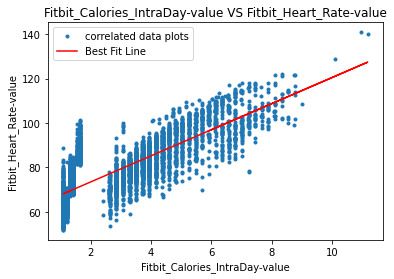

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
from numpy import polyfit

# Plotting the raw data
plt.plot(predictionData[col1], predictionData[col2], '.',zorder=0,label = "correlated data plots")

# Calculate line of best fit
m, b = np.polyfit(predictionData[col1], predictionData[col2], 1)

# Plotting slope, using the slope-intercept equation
plt.plot(predictionData[col1], b + m*predictionData[col1],'r', label = "Best Fit Line")

plt.legend()
plt.title(col1 +" VS "+ col2)
plt.xlabel(col1)
plt.ylabel(col2)
plt.figure()
plt.show()

Assuming our model is able to train well, the resulting slope and intercept should be similar to the values below.

In [ ]:
print("intercept:", b)
print("slope:", m)

intercept: 61.68182027279625
slope: 5.872392273097362


Now, we may produce our machine learning algorithm. Using scikit-learn, we can do this in very few lines of code. The following section includes all of the steps for splitting the data into a training and testing set, creating the model, and then training the model.

In [ ]:
# Importing sklearn libraries for training and linear regression
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

# Preparing data and labels
X = predictionData.iloc[:, :-1].values #first column in dataframe
y = predictionData.iloc[:, 1].values #second column in dataframe

# Splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) 

# sklearn allows us to create a model in just one line of code
regressor = LinearRegression()

# Training is equally simple when using the fit() function on our model
regressor.fit(X_train, y_train);

Now that the model is trained, we can test our results and compare the predictions to their true values.

In [ ]:
# Predicting values for training and testing 
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)

print("Predictions for test dataset: ")
df = pd.DataFrame({value1: X_test[:,0], "Actual "+value2: y_test, "Predicted "+value2: test_predictions})
df

Predictions for test dataset: 


,Fitbit_Heart_Rate-value,Actual Fitbit_Calories_IntraDay-value,Predicted Fitbit_Calories_IntraDay-value
0,3.51072,76.333333,82.217297
1,3.29130,78.777778,80.934994
2,1.42623,74.888889,70.035417
3,1.31652,70.555556,69.394265
4,1.09710,61.777778,68.111963
...,...,...,...
1654,1.31652,78.900000,69.394265
1655,1.09710,65.888889,68.111963
1656,1.09710,59.090909,68.111963
1657,1.53118,89.555556,70.648751


Error scores are used by our machine learning model to calculate the distance from our predictions to the actual real-world values. During training and testing, these values are automatically produced and used by the model to improve its predictions, with the goal of minimizing these errors. We can use sklearn.metrics to calculate and return a sample of different types of errors that can be calculated below. Note that on average the training error rate should be lower than the corresponding testing error rate. Can you think of why this should be the case?

In [ ]:
# Importing metrics from sklearn to calculate errors
from sklearn import metrics

print('Mean Absolute Error of training results:', metrics.mean_absolute_error(y_train, train_predictions))
print('Mean Squared Error of training results:', metrics.mean_squared_error(y_train, train_predictions))
print('Root Mean Squared Error of training results:', np.sqrt(metrics.mean_squared_error(y_train, train_predictions)))
print()
print('Mean Absolute Error of testing results:', metrics.mean_absolute_error(y_test, test_predictions))
print('Mean Squared Error of testing results:', metrics.mean_squared_error(y_test, test_predictions))
print('Root Mean Squared Error of testing results:', np.sqrt(metrics.mean_squared_error(y_test, test_predictions)))

Mean Absolute Error of training results: 5.937544187754273
Mean Squared Error of training results: 56.735339145621374
Root Mean Squared Error of training results: 7.532286448723347

Mean Absolute Error of testing results: 6.017929157807114
Mean Squared Error of testing results: 59.15155703824491
Root Mean Squared Error of testing results: 7.691004943324696


Along with the analysis we have done so far, we can also plot the regression function that has been produced by our model alongside both our training data and our testing data.

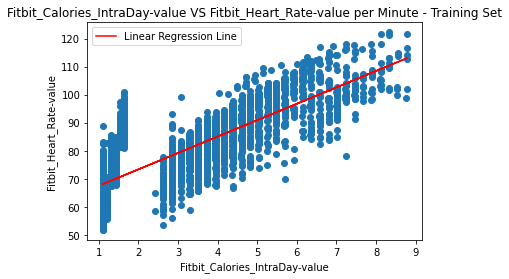

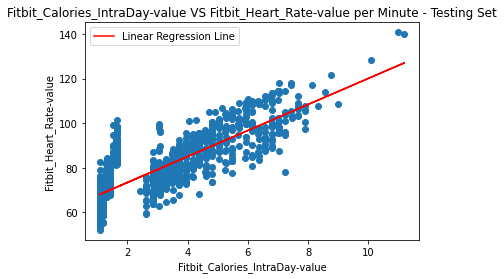

In [ ]:
# Visualizing the training set results
plt_train = plt
plt_train.scatter(X_train, y_train,zorder = 0)
plt_train.plot(X_train, regressor.predict(X_train), color='red',label = "Linear Regression Line")
plt_train.legend()
plt_train.title(col1 + " VS " + col2 + " per Minute - Training Set")
plt_train.xlabel(col1)
plt_train.ylabel(col2)
plt_train.show()

print()

# Visualizing the testing set results
plt_test = plt
plt_test.scatter(X_test, y_test,zorder = 0)
plt_test.plot(X_test, regressor.predict(X_test), color='red',label = "Linear Regression Line")
plt_test.legend()
plt_test.title(col1 + " VS " + col2 + " per Minute - Testing Set")
plt_test.xlabel(col1)
plt_test.ylabel(col2)
plt_test.show()

We can also view the difference between our model's approximated best fit line and the one calculated using the numpy.polyfit fitting method from before.

In [ ]:
print("Line of Best Fit:")
print("intercept:", b)
print("slope:", m)

print("\nOur Model's Approximated Best Fit Line:")
print("intercept: ",regressor.intercept_)
print("slope: ",regressor.coef_)

Line of Best Fit:
intercept: 61.68182027279625
slope: 5.872392273097362

Our Model's Approximated Best Fit Line:
intercept:  61.70044663618225
slope:  [5.84405776]


\* Note: If we already have a method which can determine the exact line of best fit, why would we want to make a model which is less efficient and less accurate?

We wouldn't.

Machine learning is valuable when dealing with higher-dimensional data with more complex relationships. This is a proof of concept, but machine learning algorithms really shine when put into use where other methods fail.

Now that our model is trained, we can now use it to make predictions on our selected variable. Using the code below, you can enter a value to see the predicted results!

In [ ]:
tst = int(input("please enter any " + col1 + " to predict " + col2 + ": "))

user_pred = regressor.predict(np.array([tst]).reshape(-1, 1))

print(user_pred)

please enter any Fitbit_Calories_IntraDay-value to predict Fitbit_Heart_Rate-value: 7
[102.60885094]
